# Classification (First analysis and considerations)

Import the libraries necessary to analize data

In [38]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydotplus
import scikitplot as skplt
import seaborn as sns
from IPython.display import Image
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import precision_score, recall_score, classification_report
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

Just to remember, all missing values was fixed in data preparation

In [39]:
df = pd.read_csv('../Task1/df_after_dp.csv', parse_dates=['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166664 entries, 0 to 166663
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       166664 non-null  datetime64[ns]
 1   state                      166664 non-null  object        
 2   city_or_county             166664 non-null  object        
 3   latitude                   166664 non-null  float64       
 4   longitude                  166664 non-null  float64       
 5   congressional_district     166664 non-null  int64         
 6   avg_age_participants       166664 non-null  float64       
 7   n_participants_child       166664 non-null  int64         
 8   n_participants_teen        166664 non-null  int64         
 9   n_females                  166664 non-null  float64       
 10  n_killed                   166664 non-null  float64       
 11  n_injured                  166664 non-null  float64 

The classification task requires to predict whether in the incident there were killed people. Hence we create the binary attribute isKilled

In [40]:
df['isKilled'] = np.where(df['n_killed'] > 0, 1, 0)
df['isKilled'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 166664 entries, 0 to 166663
Series name: isKilled
Non-Null Count   Dtype
--------------   -----
166664 non-null  int32
dtypes: int32(1)
memory usage: 651.2 KB


## Discretize categorical values

We discretize the categorical values to use them in the classification task

In [41]:
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [42]:
to_discretize = ['date', 'state', 'city_or_county', 'party']
df = discretize_data(df, to_discretize)

Dropping non-discretized columns

In [43]:
df.drop(columns=['date', 'state', 'city_or_county', 'party'], axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166664 entries, 0 to 166663
Data columns (total 32 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   latitude                   166664 non-null  float64
 1   longitude                  166664 non-null  float64
 2   congressional_district     166664 non-null  int64  
 3   avg_age_participants       166664 non-null  float64
 4   n_participants_child       166664 non-null  int64  
 5   n_participants_teen        166664 non-null  int64  
 6   n_females                  166664 non-null  float64
 7   n_killed                   166664 non-null  float64
 8   n_injured                  166664 non-null  float64
 9   n_arrested                 166664 non-null  float64
 10  n_unharmed                 166664 non-null  float64
 11  n_participants             166664 non-null  float64
 12  incident_characteristics1  166664 non-null  object 
 13  povertyPercentage          16

## Eliminating dependent columns

<Axes: >

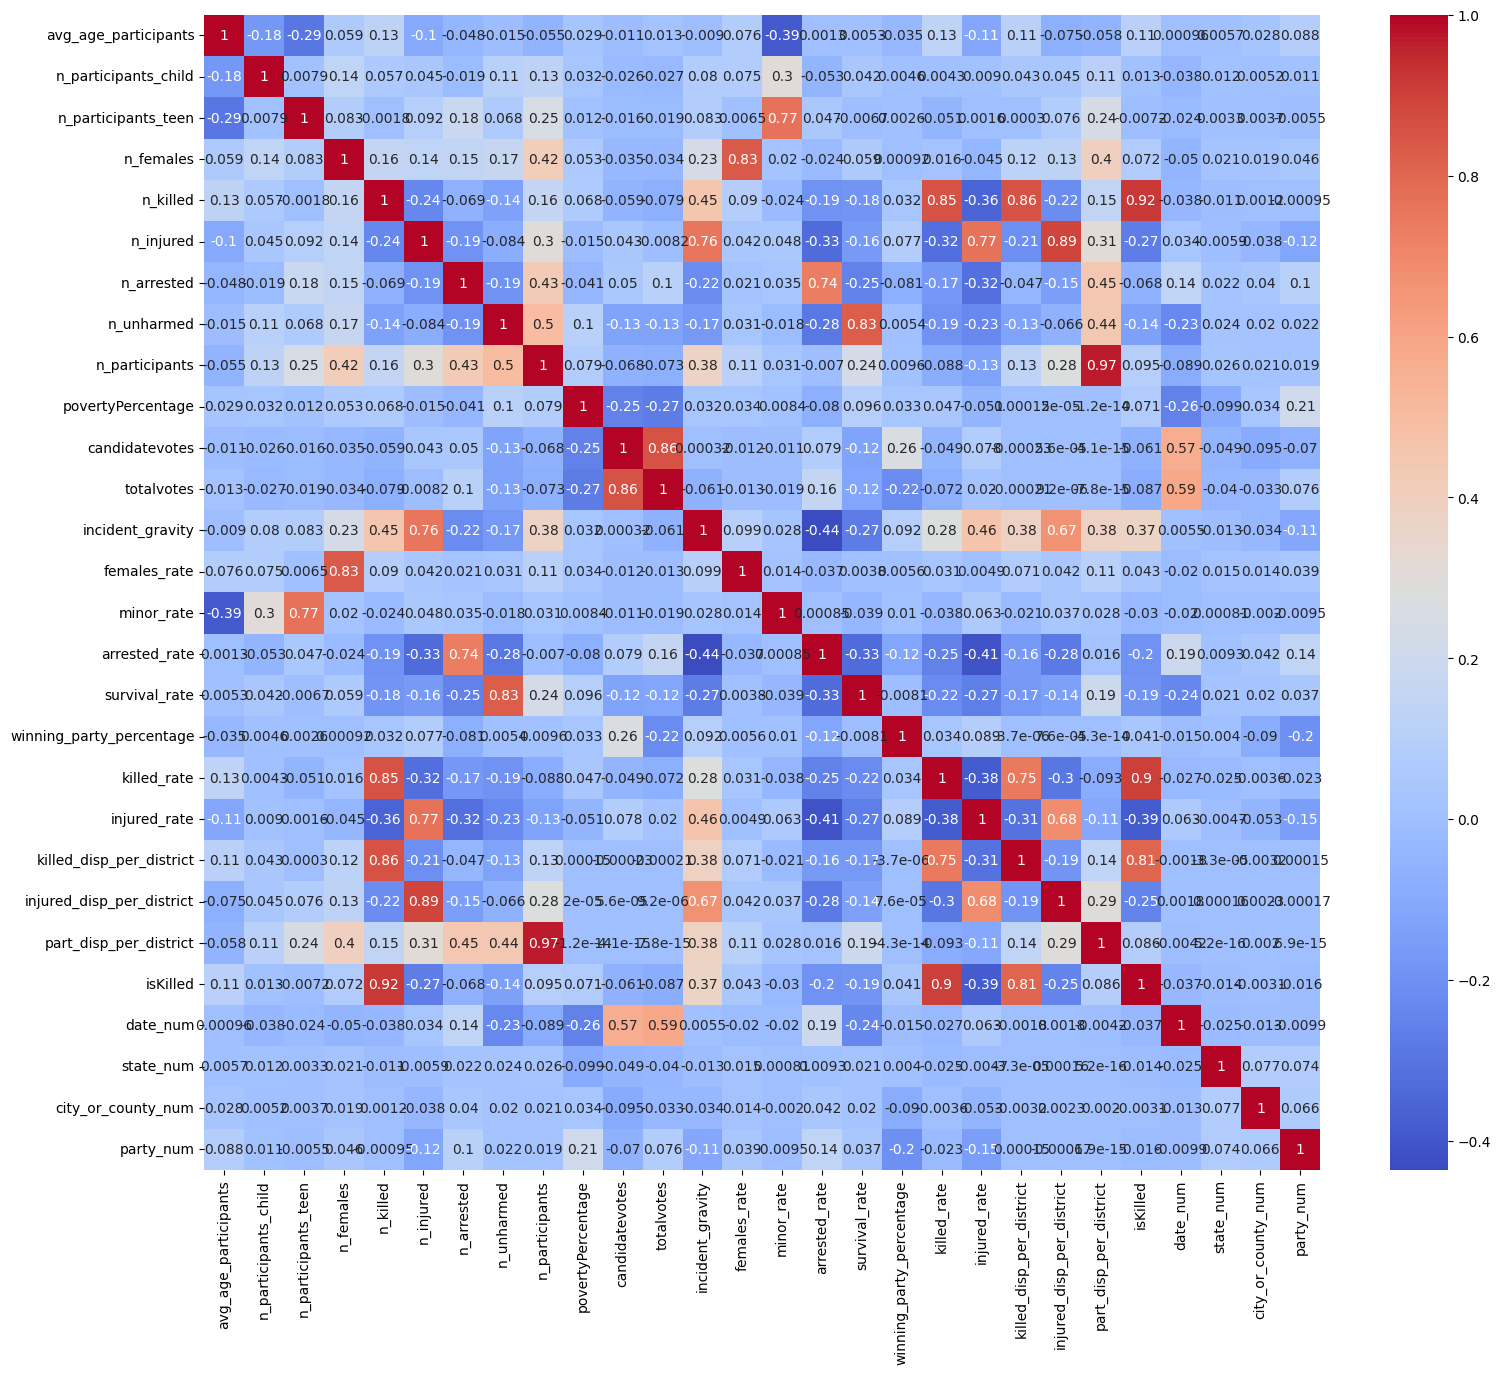

In [44]:
col_to_plot = [i for i in list(df.columns) if i not in ['latitude', 'longitude', 'date','congressional_district']] 
corr_matrix_ind = df[col_to_plot].corr(numeric_only=True, method='pearson')
plt.figure(figsize=(18,15))
sns.heatmap(corr_matrix_ind, annot=True, cmap='coolwarm')

In [45]:
df[(df['n_killed'] == (df["n_participants"] - (df["n_injured"] + df["n_unharmed"] + df["n_arrested"])))][["n_participants","n_killed","n_injured","n_unharmed","n_arrested"]]

,n_participants,n_killed,n_injured,n_unharmed,n_arrested
0,1.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,1.0
3,1.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...
166659,3.0,0.0,0.0,3.0,0.0
166660,3.0,0.0,0.0,3.0,0.0
166661,3.0,0.0,1.0,2.0,0.0
166662,5.0,0.0,3.0,2.0,0.0


We dropped all the cluster indicators, as they are all highly correlated with the original features. Moreover, we decided to discard also _latitude_ and _longitude_, as, after the data preparation steps, they become a sort of incident id (each incident has a unique couple of values after the data preparation), so irrelevant. Other columns that were dropped were:

a. _n\_killed_, because highly correlated with _isKilled_; 

b. _candidatevotes_ and _totalvotes_ because they add only further details to the majority winning party represented already by the attribute _party_, so we considered them irrelevant;

c. _incident\_characteristics1_ because it can be easily identified as a sort of class label for each record and we think it would simplify too much the classification task.


In [46]:
col_to_drop = ['latitude', 'longitude', 'n_killed', 'candidatevotes', 'totalvotes', 'incident_characteristics1', 'incident_gravity', 'females_rate',
       'minor_rate', 'arrested_rate', 'survival_rate',  'killed_rate', 'injured_rate',
       'killed_disp_per_district', 'injured_disp_per_district',
       'part_disp_per_district', 'winning_party_percentage'] #'n_injured', 'n_unharmed',

df.drop(columns=col_to_drop, axis=1,inplace=True)

<Axes: >

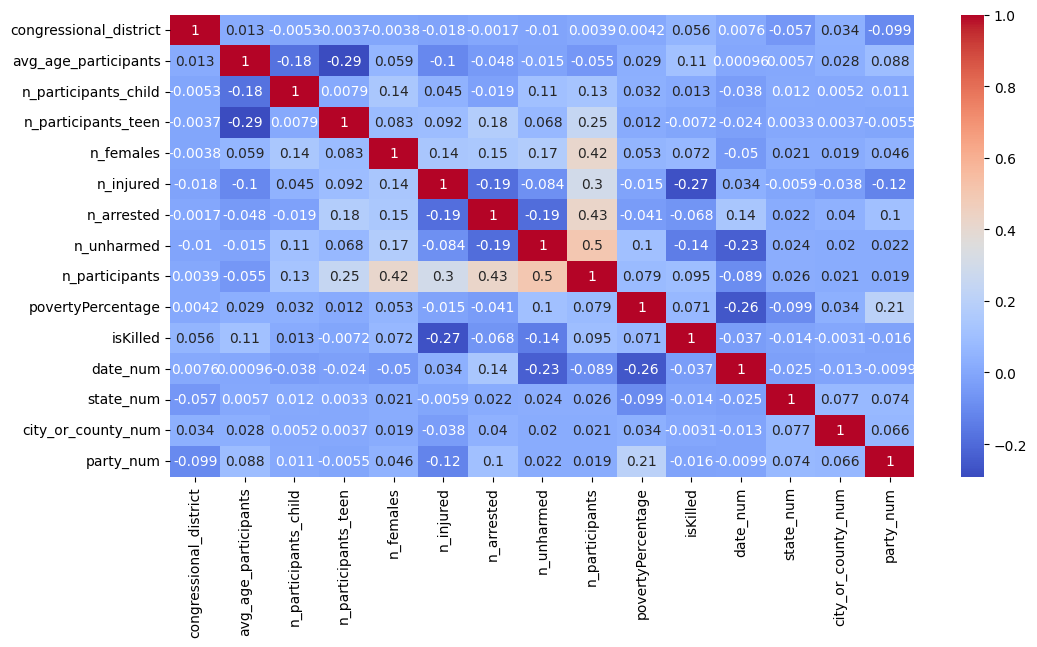

In [47]:
plt.figure(figsize=(12,6))
corr_matrix_ind = df.corr(numeric_only=True, method='pearson')
corr_matrix_ind
sns.heatmap(corr_matrix_ind, annot=True, cmap='coolwarm')

## Classification setting

Checking label distribution, we found out that our dataset is unbalanced towards the negative labels (no kill). Only 26% of labels is positive, indeed.

In [48]:
df['isKilled'].value_counts(True)

isKilled
0    0.736896
1    0.263104
Name: proportion, dtype: float64

We partitioned the dataset into training, validation, and test sets using a 70/30 split. We use a stratified splitting approach.

In [49]:
label = df.pop('isKilled')

In [50]:
X_trvl, X_test, y_trvl, y_test = train_test_split(df, label, test_size=0.30,random_state=10, stratify=label)

We standardize data, then we will observe if undersampling and oversampling help classification methods to perform better 

In [51]:
scaler = StandardScaler()
X_sc_trvl = scaler.fit_transform(X_trvl)
X_sc_test = scaler.fit_transform(X_test)


We use a stratified cross validation approach for the model selection.

In [52]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Utilities

In [53]:
#Function to print the metrics resulting from cross-validation evaluation (accuracy, precision, recall, f1, roc_auc)
def print_metrics_cv(results_hp_search, model_name):
    index_best_model = results_hp_search.best_index_ 
    results_dict = results_hp_search.cv_results_
    metrics_list=['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    print(f"CV best configuration for {model_name}:")
    print(f"best parameters {results_dict['params'][index_best_model]}")
    for i in metrics_list:        
        print(f'Mean {i} train set: {results_dict[f"mean_train_{i}"][index_best_model]} +/- {results_dict[f"std_train_{i}"][index_best_model]}')
    print("\n")
    for i in metrics_list:
        print(f'Mean {i} validation set: {results_dict[f"mean_test_{i}"][index_best_model]} +/- {results_dict[f"std_test_{i}"][index_best_model]}')
    print("\n")

In [54]:
# Function that prints the classification report
def print_report_score(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['NotKilled', 'isKilled']))

# Function that prints the confusion matrix
def print_confusion_matrix(test_label, pred_label, model):
    cm = confusion_matrix(test_label, pred_label)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()

In [55]:
# Function extracting each grid from dictionary of grids
def list_grids(grids_dict):
    return [grids_dict[item] for item in grids_dict]

# Function performing gridsearch cv according to sklearn and saving results as a csv
def do_sklearn_GridSearchCV(model_name,model,param_grid,scoring,refit,cv,return_train_score,n_jobs,X_encoded,y):
    hp_search = GridSearchCV(model,
                                param_grid=param_grid,
                                scoring=scoring,
                                refit=refit,
                                cv=cv,
                                return_train_score=return_train_score,
                                n_jobs=n_jobs,
                                verbose=10
                                ).fit(X_encoded, y)


    results = pd.DataFrame(hp_search.cv_results_)
    if not os.path.isdir(f"cv_results_all_feat_unb/"):
        os.mkdir(f"cv_results_all_feat_unb/")

    results.to_csv(f"cv_results_all_feat_unb/{model_name}_cv_results.csv")

    return hp_search

## Experiments using all features

### Logistic regression

In [56]:
params = {
       "None": {"solver": ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
              "penalty": [None]
              }
}

best_logit = do_sklearn_GridSearchCV("LogisticRegression",LogisticRegression(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,3,X_sc_trvl,y_trvl)

print_metrics_cv(best_logit,"LogisticRegression")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
CV best configuration for LogisticRegression:
best parameters {'penalty': None, 'solver': 'lbfgs'}
Mean accuracy train set: 0.9692342970267382 +/- 0.0003023154963666911
Mean precision train set: 0.9118953675155785 +/- 0.0008967528608862084
Mean recall train set: 0.9775126242058967 +/- 0.0003411042774291178
Mean f1 train set: 0.943564356892502 +/- 0.0005316635139315888
Mean roc_auc train set: 0.9773695117962646 +/- 0.0003083702922181716


Mean accuracy validation set: 0.9692278728323631 +/- 0.00119283459375965
Mean precision validation set: 0.9118812573194621 +/- 0.003596824618776152
Mean recall validation set: 0.9775207688548624 +/- 0.0014786519912572435
Mean f1 validation set: 0.9435568398221349 +/- 0.0020940666143604517
Mean roc_auc validation set: 0.9773162531228469 +/- 0.0012913962477126696




### Decision Tree

In [57]:
params = {
        "unique_entry": {
        'criterion': ['gini'],
        'max_depth': [10],
        'max_features': [None],
        'min_samples_split': [3],
        'min_samples_leaf': [1]
        }
        }
best_tree_cv = do_sklearn_GridSearchCV("DecisionTreeClassifier",DecisionTreeClassifier(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,3,X_sc_trvl,y_trvl)
print_metrics_cv(results_hp_search=best_tree_cv, model_name='DecisionTreeClassifier')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CV best configuration for DecisionTreeClassifier:
best parameters {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 3}
Mean accuracy train set: 0.9732672466819936 +/- 0.0001845051454757502
Mean precision train set: 0.9413233618392228 +/- 0.0006700523499725988
Mean recall train set: 0.9581202150187327 +/- 0.001031705545436737
Mean f1 train set: 0.9496468739549762 +/- 0.0003664114932634965
Mean roc_auc train set: 0.9941249916923898 +/- 5.432657207558135e-05


Mean accuracy validation set: 0.967804974789787 +/- 0.0012142351787434245
Mean precision validation set: 0.9309092873035153 +/- 0.0026709425299407275
Mean recall validation set: 0.9480045610034207 +/- 0.004336014066735065
Mean f1 validation set: 0.939371438342285 +/- 0.002352976793445453
Mean roc_auc validation set: 0.984094725668022 +/- 0.0013799565249148357




From these baseline methods, although they have near-default hyperparameters and they are tested on unbalanced dataset without even weighting the classes, we can observe how Logistic Regression and Decision Tree can easily reach more than 95% on accuracy, recall, area under the ROC curve and over 91-93% in precision, recall and f1.

## Experiments deleting _n\_injured_ and _n\_unharmed_ and working with balanced datasets

we decide to drop also _n\_injured_ and _n\_unharmed_, because we consider this information harder to find immediately by police investigation w.r.t. _n\_arrested_, and more uncertain, as it can grow in time and it can be uncertain. Finally, we prefer to leave a more general information represented by _n\_participants_.

In [58]:
df.drop(columns=['n_injured', 'n_unharmed'], axis=1,inplace=True)

Rerunning splitting procedures

In [59]:
X_trvl, X_test, y_trvl, y_test = train_test_split(df, label, test_size=0.30,random_state=10, stratify=label)

Re-running scaling procedures and performing oversampling and undersampling

In [60]:
scaler = StandardScaler()
X_sc_trvl = scaler.fit_transform(X_trvl)
X_sc_test = scaler.fit_transform(X_test)

print(y_trvl.value_counts(True))


oversample = RandomOverSampler(sampling_strategy='minority',random_state=15)
X_sc_trvl_oversampled, y_trvl_oversampled = oversample.fit_resample(X_sc_trvl, y_trvl)
print(y_trvl_oversampled.value_counts(True))


undersample = RandomUnderSampler(sampling_strategy='majority',random_state=15)
X_sc_trvl_undersample, y_trvl_undersample = undersample.fit_resample(X_sc_trvl, y_trvl)
print(y_trvl_undersample.value_counts(True))

isKilled
0    0.736894
1    0.263106
Name: proportion, dtype: float64
isKilled
0    0.5
1    0.5
Name: proportion, dtype: float64
isKilled
0    0.5
1    0.5
Name: proportion, dtype: float64


### Logistic Regression

With class weights

In [61]:
params = {
       "None": {"solver": ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
              "penalty": [None],
                     "class_weight":['balanced', None, {0: 0.3, 1: 0.7}, {0:1,1:2}]
              }
}

best_logit = do_sklearn_GridSearchCV("LogisticRegression",LogisticRegression(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"f1",
                        cv_strategy,True,3,X_sc_trvl,y_trvl)
print_metrics_cv(best_logit,"LogisticRegression")

Fitting 5 folds for each of 20 candidates, totalling 100 fits


CV best configuration for LogisticRegression:
best parameters {'class_weight': 'balanced', 'penalty': None, 'solver': 'sag'}
Mean accuracy train set: 0.6173048228542074 +/- 0.0011002431765125894
Mean precision train set: 0.35252459018665105 +/- 0.0009801488205656481
Mean recall train set: 0.5432399413585275 +/- 0.0012642321311359926
Mean f1 train set: 0.42757883279805775 +/- 0.0008997740152993311
Mean roc_auc train set: 0.6428647784379444 +/- 0.0006242937356086324


Mean accuracy validation set: 0.6170026898109027 +/- 0.002055831705675693
Mean precision validation set: 0.3522941352556955 +/- 0.002229883985583913
Mean recall validation set: 0.5434109789868057 +/- 0.004742396272817153
Mean f1 validation set: 0.4274587379183223 +/- 0.0028273231573487548
Mean roc_auc validation set: 0.6425201002229473 +/- 0.0014901108238177137




Oversampling

In [62]:
params = {
       "None": {"solver": ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
              "penalty": [None]}
}


In [63]:
best_logit_ov = do_sklearn_GridSearchCV("LogisticRegression_OV",LogisticRegression(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,3,X_sc_trvl_oversampled,y_trvl_oversampled)
print_metrics_cv(best_logit_ov,"LogisticRegression_OV")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
CV best configuration for LogisticRegression_OV:
best parameters {'penalty': None, 'solver': 'sag'}
Mean accuracy train set: 0.5928285206430065 +/- 0.0003441326211338223
Mean precision train set: 0.6032056250087902 +/- 0.00045163640008129865
Mean recall train set: 0.5425560376767411 +/- 0.00034370627296440807
Mean f1 train set: 0.5712754894014385 +/- 0.0002817415016063504
Mean roc_auc train set: 0.6417528781041177 +/- 0.0005474785895466247


Mean accuracy validation set: 0.5924868513928552 +/- 0.001884161778113687
Mean precision validation set: 0.6027893812641174 +/- 0.002291021050534228
Mean recall validation set: 0.5423931940835687 +/- 0.0017150619436186521
Mean f1 validation set: 0.5709970165502386 +/- 0.0017354100956198247
Mean roc_auc validation set: 0.6415566237696927 +/- 0.0020326058509947554




Undersampling

In [64]:
best_logit_und = do_sklearn_GridSearchCV("LogisticRegression_UN",LogisticRegression(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_sc_trvl_undersample,y_trvl_undersample)
print_metrics_cv(best_logit_und,"LogisticRegression_UN")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
CV best configuration for LogisticRegression_UN:
best parameters {'penalty': None, 'solver': 'lbfgs'}
Mean accuracy train set: 0.593516859423359 +/- 0.0015686327491789287
Mean precision train set: 0.603773863708869 +/- 0.0018149941077318058
Mean recall train set: 0.5441032741488843 +/- 0.0015317570958127517
Mean f1 train set: 0.5723870908032687 +/- 0.0015688970710832366
Mean roc_auc train set: 0.6436123617011673 +/- 0.0011730135438595378


Mean accuracy validation set: 0.5936145952109464 +/- 0.003173947861548008
Mean precision validation set: 0.6039130761225119 +/- 0.002949042880671786
Mean recall validation set: 0.543997393712331 +/- 0.006253563097460718
Mean f1 validation set: 0.5723831024860857 +/- 0.004647092281325365
Mean roc_auc validation set: 0.6431563336645765 +/- 0.002772168328078835




### Decision tree

With class weights

In [65]:
params = {
        "unique_entry": {
        'criterion': ['gini'],
        'max_depth': [10],
        'max_features': [None],
        'min_samples_split': [3],
        'min_samples_leaf': [1],
        "class_weight":['balanced', None, {0: 0.3, 1: 0.7}, {0:1,1:2}]
        }
        }
best_tree_cv = do_sklearn_GridSearchCV("DecisionTreeClassifier",DecisionTreeClassifier(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"f1",
                        cv_strategy,True,3,X_sc_trvl,y_trvl)
print_metrics_cv(results_hp_search=best_tree_cv, model_name='DecisionTreeClassifier')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
CV best configuration for DecisionTreeClassifier:
best parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 3}
Mean accuracy train set: 0.6912329285569571 +/- 0.004097067613030645
Mean precision train set: 0.45284583110010407 +/- 0.0035370383285745982
Mean recall train set: 0.83227724385079 +/- 0.007130248275901008
Mean f1 train set: 0.5865145116493208 +/- 0.0016531490803282326
Mean roc_auc train set: 0.8127576899872023 +/- 0.0007312169226917803


Mean accuracy validation set: 0.6738840354524229 +/- 0.0044023424508546505
Mean precision validation set: 0.43493689164841437 +/- 0.0034015357231256278
Mean recall validation set: 0.7996090568496499 +/- 0.009993932326044695
Mean f1 validation set: 0.5633646364528888 +/- 0.0017351932678161754
Mean roc_auc validation set: 0.7803889808809193 +/- 0.0020951788716574733




In [66]:
params = {
        "unique_entry": {
        'criterion': ['gini'],
        'max_depth': [10],
        'max_features': [None],
        'min_samples_split': [3],
        'min_samples_leaf': [1]
        }
        }

Oversampling

In [67]:
best_tree_balanced_ov = do_sklearn_GridSearchCV("DecisionTreeClassifier_OV",DecisionTreeClassifier(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,3,X_sc_trvl_oversampled,y_trvl_oversampled)
print_metrics_cv(results_hp_search=best_tree_balanced_ov, model_name='DecisionTreeClassifier_OV')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CV best configuration for DecisionTreeClassifier_OV:
best parameters {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 3}
Mean accuracy train set: 0.7372454020391884 +/- 0.0008691589152865158
Mean precision train set: 0.7038191057976084 +/- 0.005228796101293393
Mean recall train set: 0.8195978344419217 +/- 0.013664562738437715
Mean f1 train set: 0.7572000050207881 +/- 0.0030214754840058805
Mean roc_auc train set: 0.8138547282286126 +/- 0.0008687043561235964


Mean accuracy validation set: 0.7249531835156898 +/- 0.0010581156240757374
Mean precision validation set: 0.6926765798409165 +/- 0.004384620218056352
Mean recall validation set: 0.8090006360336345 +/- 0.01316032390009766
Mean f1 validation set: 0.7462396032756082 +/- 0.0033339191954609906
Mean roc_auc validation set: 0.7960465003049616 +/- 0.0021018358666120094




Undersampling 

In [68]:
best_tree_balanced_und = do_sklearn_GridSearchCV("DecisionTreeClassifier_UN",DecisionTreeClassifier(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,3,X_sc_trvl_undersample,y_trvl_undersample)
print_metrics_cv(results_hp_search=best_tree_balanced_und, model_name='DecisionTreeClassifier_UN')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CV best configuration for DecisionTreeClassifier_UN:
best parameters {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 3}
Mean accuracy train set: 0.7407273171526307 +/- 0.0029980053462170253
Mean precision train set: 0.711674612182405 +/- 0.003194452501172606
Mean recall train set: 0.8093826356084053 +/- 0.0035667983506523712
Mean f1 train set: 0.7573847310381916 +/- 0.0026612065044776434
Mean roc_auc train set: 0.8203312983894504 +/- 0.0024075381731535382


Mean accuracy validation set: 0.7097898680566868 +/- 0.0052271643860422054
Mean precision validation set: 0.6834103113297911 +/- 0.006186035646037585
Mean recall validation set: 0.78188630070044 +/- 0.005077455428104429
Mean f1 validation set: 0.7293152964249586 +/- 0.004011980003315849
Mean roc_auc validation set: 0.774452057762344 +/- 0.0054675865300148835




### Neural Network

In [69]:
from sklearn.neural_network import MLPClassifier

In [70]:
params = {
    "unique_entry":{
    "hidden_layer_sizes": [[16]],
    "activation": ["tanh"],
    "solver": ["adam"], 
    "max_iter": [500]
}
}

In [71]:
best_mlp = do_sklearn_GridSearchCV("MLP",MLPClassifier(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,3,X_sc_trvl,y_trvl)
print_metrics_cv(best_mlp,"MLP")

Fitting 5 folds for each of 1 candidates, totalling 5 fits


CV best configuration for MLP:
best parameters {'activation': 'tanh', 'hidden_layer_sizes': [16], 'max_iter': 500, 'solver': 'adam'}
Mean accuracy train set: 0.7630245804482537 +/- 0.0009393886165834477
Mean precision train set: 0.5938481657773197 +/- 0.011150711944152202
Mean recall train set: 0.3171933539664441 +/- 0.02599393777907596
Mean f1 train set: 0.4125821365401997 +/- 0.019895603109771766
Mean roc_auc train set: 0.7933344763228263 +/- 0.0017217050832212335


Mean accuracy validation set: 0.7602173905807824 +/- 0.0017162769585811445
Mean precision validation set: 0.5833706673253641 +/- 0.006267328306554196
Mean recall validation set: 0.3113210620622251 +/- 0.02695362520315348
Mean f1 validation set: 0.40517716445800983 +/- 0.022554444802090404
Mean roc_auc validation set: 0.7891828453003182 +/- 0.0035571332100650093




oversampling

In [72]:
best_mlp_ov = do_sklearn_GridSearchCV("MLP_OV",MLPClassifier(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy", cv_strategy,True,5,X_sc_trvl_oversampled,y_trvl_oversampled)
print_metrics_cv(best_mlp_ov,"MLP_OV")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CV best configuration for MLP_OV:
best parameters {'activation': 'tanh', 'hidden_layer_sizes': [16], 'max_iter': 500, 'solver': 'adam'}
Mean accuracy train set: 0.7203090712534129 +/- 0.0019259818736446065
Mean precision train set: 0.6929838475076492 +/- 0.0021583501943783275
Mean recall train set: 0.7911747406496826 +/- 0.009249140648918153
Mean f1 train set: 0.738795695181484 +/- 0.0033180366266152184
Mean roc_auc train set: 0.7932628018916543 +/- 0.0015217416841407795


Mean accuracy validation set: 0.718538061994133 +/- 0.0015619568114291493
Mean precision validation set: 0.6914475792698033 +/- 0.0021654126525667947
Mean recall validation set: 0.789365891901236 +/- 0.008887459578516083
Mean f1 validation set: 0.7371345846686488 +/- 0.0029921857593372507
Mean roc_auc validation set: 0.7903971185591685 +/- 0.0015932773031140757




undersampling

In [73]:
best_mlp_und = do_sklearn_GridSearchCV("MLP_UN",MLPClassifier(),list_grids(params),['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_sc_trvl_undersample,y_trvl_undersample)
print_metrics_cv(best_mlp_und,"MLP_UN")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CV best configuration for MLP_UN:
best parameters {'activation': 'tanh', 'hidden_layer_sizes': [16], 'max_iter': 500, 'solver': 'adam'}
Mean accuracy train set: 0.7224588695227235 +/- 0.002472628773537236
Mean precision train set: 0.6958622907236341 +/- 0.0026069589513993885
Mean recall train set: 0.7903974588695227 +/- 0.006434014935629015
Mean f1 train set: 0.7401059984123985 +/- 0.0028761716856291445
Mean roc_auc train set: 0.7963066318776015 +/- 0.0023556188936576846


Mean accuracy validation set: 0.7169245805505782 +/- 0.003053798088843116
Mean precision validation set: 0.6905429024401026 +/- 0.0031531624495521765
Mean recall validation set: 0.7861866753542922 +/- 0.0043557960354085766
Mean f1 validation set: 0.7352596142452537 +/- 0.0028267178899829704
Mean roc_auc validation set: 0.7891307317917344 +/- 0.0022516172378071395




From this analysis, using, also in this case, near-default hyperparameters for 3 methods, 2 baseline, Logistic Regression, Decision Tree, 1 more complex, Neural Network, we can observe that:

1- Without adopting over or under sampling techniques or weighting the classes, the recall reached at most 30% (see NN);

2- Adopting weighting techniques, the recall improves a lot (> + 20%), but precision is very low (between 35% and 45%).

The right techniques to use seems to be under or oversampling where recall metric is improved without damaging the precision metric. The difference between the two sampling methods does not seem to be sharp (performance differs by 0.01-0.02 percentage points at most), so we prefer to use undersampling because it is computationally less expensive to do model selection and evaluation on an undersampled dataset and we can try to explore broader grid searches and more advanced validation techniques such as stratified 5-fold cross-validation to find the best model.
We will do an exhaustive evaluation testing different models on __Classification_sel_feature_undersamp.ipynb__